In [1]:
# !pip install rdkit
# !pip install mendeleev

In [2]:
from collections import defaultdict
import copy
import math
from rdkit import Chem
from rdkit.Chem import Descriptors
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mendeleev import element

In [3]:
# sml = "C=C=O"

# Create a molecule object
# sml = "CCO"  # Example molecule: Ethanol (C2H5OH)

# Add explicit hydrogens
# Chem.AddHs(mol)

# sml = "ClC(Cl)Cl"

# Carbon tetrachloride; four Cl
# sml = "ClC(Cl)(Cl)Cl"

# sml = "c1ccccc1" # benzene; boring

# Calcium carbonate; boring
# sml = "[Ca+2].[O-]C([O-])=O"

# Potassium cyanide; three elements
sml = "[K+].[C-]#N"

# FeCl3; good for distinguishing very similar masses
# sml = "Cl[Fe](Cl)Cl"

# Cl2; simple case
# sml = "ClCl"

# Homo triatomic
# sml = "[O-][O+]=O"

# Homo diatomic
# sml = "O=O"

In [4]:
mol = Chem.AddHs(Chem.MolFromSmiles(sml))
# print(composition(mol))
print(Chem.MolToSmiles(mol))
# mol_with_hydrogens = Chem.AddHs(mol)
# print(Chem.MolToSmiles(mol_with_hydrogens))
# print(composition(mol_with_hydrogens))
# same = composition(mol) == composition(mol_with_hydrogens)
# print(same)

[C-]#N.[K+]


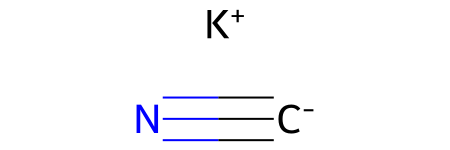

In [5]:
mol

In [6]:
class MolecularIsotope():
  """Store a molecule's isotopic properties."""
  def __init__(
      self,
      sml: str,
      abundance: float = None):
    self.sml = sml
    self.abundance = abundance
    try:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml))
    except:
      self.mol = Chem.AddHs(Chem.MolFromSmiles(sml, sanitize=False))
    self.mass = Descriptors.ExactMolWt(self.mol)
  def update(self):
    self.mass = Descriptors.ExactMolWt(self.mol)
    self.canon_sml = Chem.MolToSmiles(mol)

In [7]:
def element_set(molecule):
    """Get the set of elements in an RDKit molecule
    For example, ethanol (SMILES CCO, formula C2H5OH)
    returns {'C', 'O', 'H'}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:
      # Add hydrogen atoms--RDKit excludes them by default
      molecule_with_Hs = Chem.AddHs(molecule)
      atom_symbols = set(atom.GetSymbol() for atom in molecule_with_Hs.GetAtoms())
      return atom_symbols

In [8]:
set_of_elements = element_set(mol)
print(set_of_elements)
isotopes = {}
for element_symbol in set_of_elements:
  # print(f"{element=}")
  # print(f"{element(element)=}")
  element_isotopes = element(element_symbol).isotopes
  occurring_isotopes = [[isotope.mass_number, isotope.abundance/100] for isotope in element_isotopes if isotope.abundance != None]
  isotopes[element_symbol] = occurring_isotopes
print(isotopes)

{'C', 'N', 'K'}
{'C': [[12, 0.9894], [13, 0.0106]], 'N': [[14, 0.9962050000000001], [15, 0.003795]], 'K': [[39, 0.932581], [40, 0.000117], [41, 0.067302]]}


In [9]:
num_atoms = len(mol.GetAtoms())

# Build iterable of number of isotopes by atom index
isotopes_by_atom_index = ()
for atom_index, atom in enumerate(mol.GetAtoms()):
  atom_symbol = atom.GetSymbol()
  isotopes_by_atom_index += (len(isotopes[atom_symbol]),)

In [10]:
def set_isotopes(arr:np.ndarray, sml: str, current_index=()):
    if isinstance(arr, np.ndarray):
        for i in range(len(arr)):
            arr[i] = set_isotopes(arr=arr[i], current_index=current_index + (i,), sml=sml)
        return arr
    else:
        # For an individual item in the ndarray, create molecule, 
        # set the isotopes of each of its atoms, and calculate abundance
        item = MolecularIsotope(sml=sml)
        mol = item.mol
        abundance = 1
        for atom_index, atom in enumerate(mol.GetAtoms()):
          atom_symbol = atom.GetSymbol()
          isotope_data_to_use = isotopes[atom_symbol][current_index[atom_index]]
          isotope_to_use = isotope_data_to_use[0]
          atom.SetIsotope(isotope_to_use)
          abundance *= isotope_data_to_use[1]
        item.update()
        item.abundance = abundance          
        return item

In [11]:
# Create the empty numpy ndarray with the specified shape
mol_isotopes = np.empty(isotopes_by_atom_index, dtype=object)

# Set the isotopes for each atom in each molecule
mol_isotopes = set_isotopes(arr = mol_isotopes, sml = sml, current_index=())

In [12]:
def composition(
        molecule,
        isotopes=False):
    """Get the composition of an RDKit molecule:
    Atomic counts, including hydrogen atoms, and any charge.
    For example, fluoride ion (chemical formula F-, SMILES string [F-])
    returns {9: 1, 0: -1}.

    :param molecule: The molecule to analyze
    :type some_input: An RDKit molecule
    :rtype: A dictionary.
    """
    # Check that there is a valid molecule
    if molecule:

        # Add hydrogen atoms--RDKit excludes them by default
        Chem.AddHs(molecule)
        comp = defaultdict(lambda: 0)

        # Get atom counts
        for atom in molecule.GetAtoms():
            element_symbol = atom.GetSymbol()
            if not isotopes:
                comp[element_symbol] += 1
            else:
                isotope = atom.GetIsotope()
                try:
                    comp[element_symbol][isotope] += 1
                except:
                    comp[element_symbol] = defaultdict(lambda: 0)
                    comp[element_symbol][isotope] += 1
        return comp

In [13]:
composition(mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'K': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1}),
             'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1}),
             'N': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {0: 1})})

In [14]:
def flatten_ndarray(arr):
    flat_list = []
    for element in arr:
        if isinstance(element, np.ndarray):
            flat_list.extend(flatten_ndarray(element))
        else:
            flat_list.append(element)
    return flat_list

In [15]:
def binomial_coefficient(n, k):
    return math.factorial(n) // (math.factorial(k) * math.factorial(n - k))

In [16]:
def distribute_items(n, k):
    def backtrack(remaining_items, bins, current_bin):
        if current_bin == k:
            if remaining_items == 0:
                results.append(list(bins))
            return

        for items_in_current_bin in range(remaining_items + 1):
            bins[current_bin] = items_in_current_bin
            backtrack(remaining_items - items_in_current_bin, bins, current_bin + 1)

    results = []
    bins = [0] * k
    backtrack(n, bins, 0)
    return results

In [17]:
mol_isotopes_flat = flatten_ndarray(mol_isotopes)
mol_isotopes_flat.sort(key=lambda x:x.mass)

In [18]:
# Function to flatten nested defaultdict into a flat dictionary
def flatten_dict(d, parent_key='', sep='_'):
    items = []
    for k, v in d.items():
        new_key = f"{parent_key}{sep}{k}" if parent_key else k
        if isinstance(v, dict):
            items.extend(flatten_dict(v, new_key, sep=sep).items())
        else:
            items.append((new_key, v))
    return dict(items)

In [19]:
composition(mol_isotopes_flat[0].mol, isotopes=True)

defaultdict(<function __main__.composition.<locals>.<lambda>()>,
            {'K': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {39: 1}),
             'C': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {12: 1}),
             'N': defaultdict(<function __main__.composition.<locals>.<lambda>()>,
                         {14: 1})})

In [20]:
import polars as pl
data_dict_list = []
for mol_isotope in mol_isotopes_flat:
    data_dict = {prop: getattr(mol_isotope, prop) for prop in vars(mol_isotope).keys()}
    data_dict["mol_isotope"] = mol_isotope
    flat_composition = flatten_dict(composition(mol_isotope.mol, isotopes=True))
    sorted_flat_composition = {key: flat_composition[key] for key in sorted(flat_composition)}
    data_dict["composition"] = str(sorted_flat_composition)
    data_dict_list.append(data_dict)
df = pl.DataFrame(data_dict_list)
df

sml,abundance,mol,mass,canon_sml,mol_isotope,composition
str,f64,object,f64,str,object,str
"""[K+].[C-]#N""",0.919194,<rdkit.Chem.rdchem.Mol object at 0x16398cba0>,64.966781,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f7b10>,"""{'C_12': 1, 'K…"
"""[K+].[C-]#N""",0.003502,<rdkit.Chem.rdchem.Mol object at 0x16398ce40>,65.963816,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f5610>,"""{'C_12': 1, 'K…"
"""[K+].[C-]#N""",0.000115,<rdkit.Chem.rdchem.Mol object at 0x163a198c0>,65.967072,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f5c50>,"""{'C_12': 1, 'K…"
"""[K+].[C-]#N""",0.009848,<rdkit.Chem.rdchem.Mol object at 0x16398f290>,65.970136,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f5b50>,"""{'C_13': 1, 'K…"
"""[K+].[C-]#N""",4.3931e-7,<rdkit.Chem.rdchem.Mol object at 0x163a19930>,66.964107,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f45d0>,"""{'C_12': 1, 'K…"
"""[K+].[C-]#N""",0.066336,<rdkit.Chem.rdchem.Mol object at 0x163a19a80>,66.9649,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x162a864d0>,"""{'C_12': 1, 'K…"
"""[K+].[C-]#N""",0.000038,<rdkit.Chem.rdchem.Mol object at 0x163a19850>,66.96717,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x1648f5650>,"""{'C_13': 1, 'K…"
"""[K+].[C-]#N""",0.000001,<rdkit.Chem.rdchem.Mol object at 0x163a199a0>,66.970427,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x16322d590>,"""{'C_13': 1, 'K…"
"""[K+].[C-]#N""",0.000253,<rdkit.Chem.rdchem.Mol object at 0x163a19af0>,67.961935,"""[C-]#N.[K+]""",<__main__.MolecularIsotope object at 0x162a85790>,"""{'C_12': 1, 'K…"


In [21]:
agg_exprs = [
    pl.sum("abundance").alias("abundance")
] + [
    pl.col(col).first().alias(col)
    for col in df.columns
    if col not in ("composition", "abundance")
]
result_df = df.group_by("composition").agg(agg_exprs)

In [22]:
result_df = result_df.sort("mass")

In [23]:
print(result_df[1]["composition"].item())
print(result_df[1]["mass"].item())

{'C_12': 1, 'K_39': 1, 'N_15': 1}
65.96381558


In [24]:
print(result_df[2]["composition"].item())
print(result_df[2]["mass"].item())

{'C_12': 1, 'K_40': 1, 'N_14': 1}
65.96707248


It might be tempting to match molecules by mass, but a floating-point value can have some error or uncertainty. In some cases, the mass differences between different species can be quite small (for example less than 0.002 amu if the sum of the mass numbers is the same), so adding a tolerance risks lumping different molecules together. So it's best to use some discrete identifier. In this case, we use the SMILES, which contains isotope labels.

In [25]:
mol_isotopes_agg_rows = result_df.rows(named=True)
mol_isotopes_agg_mols = [row["mol"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_masses = [row["mass"] for row in mol_isotopes_agg_rows]
mol_isotopes_agg_abundances = [row["abundance"] for row in mol_isotopes_agg_rows]
legends = [f"{mass:.9f}: {abundance:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]
# legends = [f"{mass:.3f if abundance > 0.01 else mass:.3e}: {abundance:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]
# legends = [f"{mass:.3f}" if abundance > 0.01 else f"{mass:.3e}" for mass, abundance in zip(mol_isotopes_agg_masses, mol_isotopes_agg_abundances)]


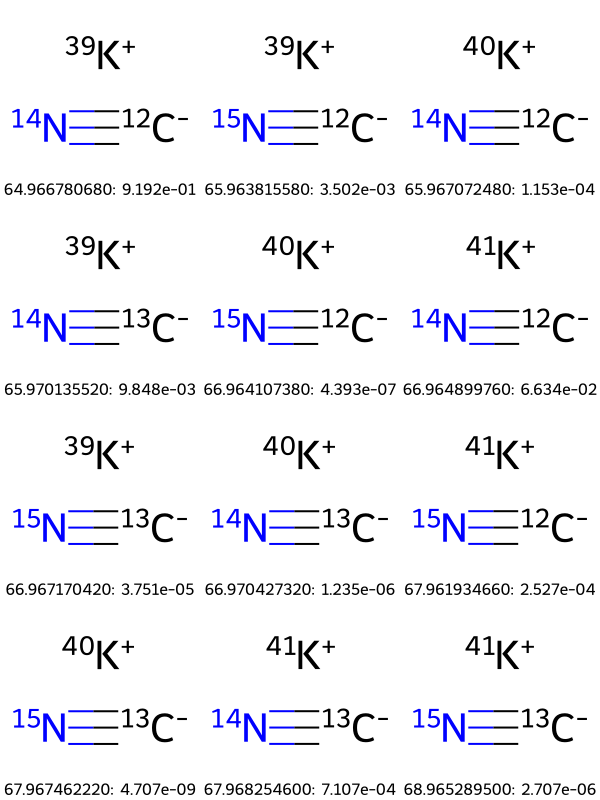

In [26]:
# Chem.Draw.MolsToGridImage(mols = mol_isotopes_agg_mols, legends = legends, maxMols=len(mol_isotopes_agg_rows))
Chem.Draw.MolsToGridImage(mols = mol_isotopes_agg_mols, legends = legends)

In [27]:
abundance_sum = sum(mol_isotopes_agg_abundances)
print(abundance_sum)

1.0


In [28]:
df_pandas_all = pd.DataFrame({
    'Mass': mol_isotopes_agg_masses,
    'Abundance': mol_isotopes_agg_abundances
})

In [29]:
df_pandas_all

,Mass,Abundance
0,64.966781,9.191940e-01
1,65.963816,3.501630e-03
2,65.967072,1.153205e-04
3,65.970136,9.847844e-03
4,66.964107,4.393084e-07
5,66.964900,6.633590e-02
6,66.967170,3.751494e-05
7,66.970427,1.235493e-06
8,67.961935,2.527037e-04
9,67.967462,4.706559e-09


In [30]:
df_pandas = df_pandas_all.loc[df_pandas_all['Abundance'] >= 0.0000000000000001]

/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/jemonat/Projects/bertiewooster.github.io/venv/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


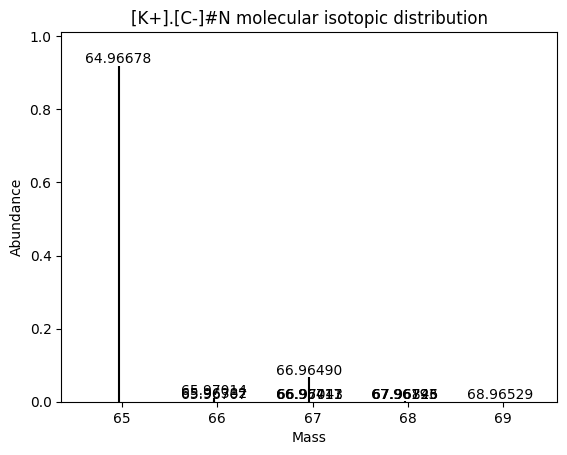

In [31]:
# Create the scatter plot using Seaborn
sns.scatterplot(x='Mass', y='Abundance', data=df_pandas, marker='')

plt.xlabel('Mass')
plt.ylabel('Abundance')
plt.title(f'{sml} molecular isotopic distribution')

# Adjust x-axis limits to allow more space on the left and right for labels
xrange = max(df_pandas['Mass']) - min(df_pandas['Mass'])
xpad = xrange * 0.15
plt.xlim(min(df_pandas['Mass']) - xpad, max(df_pandas['Mass']) + xpad)

# Adjust y-axis limits to start at zero and allow more space on the top for labels
yrange = max(df_pandas['Abundance']) - min(df_pandas['Abundance'])
ypad = yrange * 0.1
plt.ylim(0, max(df_pandas['Abundance']) + ypad)

# Add vertical lines from each data point to the x-axis
for x, y in zip(df_pandas['Mass'], df_pandas['Abundance']):
    plt.vlines(x=x, ymin=0, ymax=y, colors='black')
    # Label the data points by mass
    plt.text(x=x, y=y, s=f'{x:.5f}', ha='center', va='bottom')

plt.show()